In [1]:
import torch
import torchvision.models as models
import numpy as np
import time
import platform

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("System:", platform.system())


PyTorch version: 2.5.1+cu118
CUDA available: True
Device name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design
System: Windows


In [2]:
# Benchmark configuration
BATCH_SIZES = [1, 8, 16, 32]
NUM_RUNS = 50
IMAGE_SIZE = 224

device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda") if torch.cuda.is_available() else None


In [3]:
# Load pretrained ResNet18
model = models.resnet18(pretrained=True)
model.eval()

print("Model loaded: ResNet18")


Model loaded: ResNet18


d:\AI_ML\ai_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AI_ML\ai_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def benchmark_inference(model, device, batch_size):
    model.to(device)
    
    # Dummy input
    inputs = torch.randn(batch_size, 3, IMAGE_SIZE, IMAGE_SIZE).to(device)
    
    # Warm-up runs
    for _ in range(10):
        with torch.no_grad():
            _ = model(inputs)
        if device.type == "cuda":
            torch.cuda.synchronize()
    
    times = []
    
    # Timed runs
    with torch.no_grad():
        for _ in range(NUM_RUNS):
            start = time.time()
            _ = model(inputs)
            if device.type == "cuda":
                torch.cuda.synchronize()
            end = time.time()
            times.append(end - start)
    
    mean_time = np.mean(times)
    std_time = np.std(times)
    throughput = batch_size / mean_time
    
    return mean_time, std_time, throughput


In [5]:
cpu_results = {}

for bs in BATCH_SIZES:
    mean_t, std_t, fps = benchmark_inference(model, device_cpu, bs)
    cpu_results[bs] = (mean_t, std_t, fps)
    print(f"CPU | Batch {bs}: {mean_t:.4f}s ± {std_t:.4f}s | Throughput: {fps:.2f} samples/sec")


CPU | Batch 1: 0.0375s ± 0.0103s | Throughput: 26.66 samples/sec
CPU | Batch 8: 0.2071s ± 0.0154s | Throughput: 38.63 samples/sec
CPU | Batch 16: 0.4299s ± 0.0179s | Throughput: 37.22 samples/sec
CPU | Batch 32: 0.8717s ± 0.0615s | Throughput: 36.71 samples/sec


In [6]:
gpu_results = {}

if device_gpu:
    for bs in BATCH_SIZES:
        mean_t, std_t, fps = benchmark_inference(model, device_gpu, bs)
        gpu_results[bs] = (mean_t, std_t, fps)
        print(f"GPU | Batch {bs}: {mean_t:.4f}s ± {std_t:.4f}s | Throughput: {fps:.2f} samples/sec")
else:
    print("GPU not available. CPU-only benchmarking performed.")


GPU | Batch 1: 0.0044s ± 0.0012s | Throughput: 229.17 samples/sec
GPU | Batch 8: 0.0112s ± 0.0008s | Throughput: 716.86 samples/sec
GPU | Batch 16: 0.0164s ± 0.0009s | Throughput: 974.24 samples/sec
GPU | Batch 32: 0.0310s ± 0.0011s | Throughput: 1033.00 samples/sec


In [7]:
import pandas as pd

data = []

for bs in BATCH_SIZES:
    cpu_mean, cpu_std, cpu_fps = cpu_results[bs]
    gpu_mean, gpu_std, gpu_fps = gpu_results.get(bs, (None, None, None))
    
    data.append([
        bs,
        cpu_mean, cpu_fps,
        gpu_mean, gpu_fps
    ])

df = pd.DataFrame(
    data,
    columns=[
        "Batch Size",
        "CPU Latency (s)", "CPU Throughput",
        "GPU Latency (s)", "GPU Throughput"
    ]
)

df


,Batch Size,CPU Latency (s),CPU Throughput,GPU Latency (s),GPU Throughput
0,1,0.037507,26.661398,0.004364,229.169389
1,8,0.207108,38.627116,0.011160,716.860468
2,16,0.429871,37.220475,0.016423,974.238554
3,32,0.871686,36.710454,0.030978,1033.001247


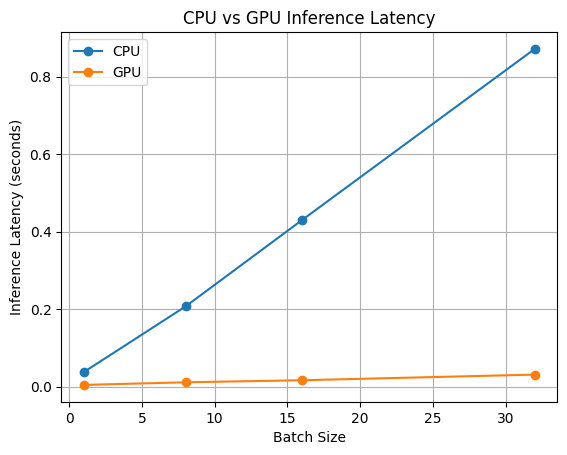

In [8]:
import matplotlib.pyplot as plt

cpu_latency = [cpu_results[bs][0] for bs in BATCH_SIZES]
gpu_latency = [gpu_results[bs][0] for bs in BATCH_SIZES] if gpu_results else None

plt.figure()
plt.plot(BATCH_SIZES, cpu_latency, marker='o', label="CPU")
if gpu_latency:
    plt.plot(BATCH_SIZES, gpu_latency, marker='o', label="GPU")

plt.xlabel("Batch Size")
plt.ylabel("Inference Latency (seconds)")
plt.title("CPU vs GPU Inference Latency")
plt.legend()
plt.grid(True)
plt.show()


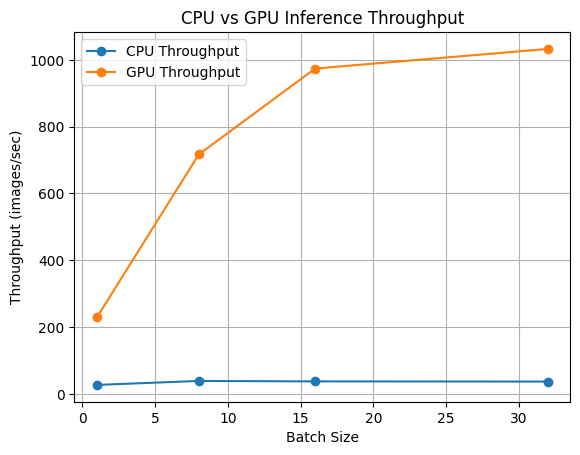

In [9]:
import matplotlib.pyplot as plt
import os

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Extract throughput values
cpu_throughput = [cpu_results[bs][2] for bs in BATCH_SIZES]

gpu_throughput = (
    [gpu_results[bs][2] for bs in BATCH_SIZES]
    if gpu_results else None
)

# Plot
plt.figure()
plt.plot(BATCH_SIZES, cpu_throughput, marker='o', label="CPU Throughput")

if gpu_throughput:
    plt.plot(BATCH_SIZES, gpu_throughput, marker='o', label="GPU Throughput")

plt.xlabel("Batch Size")
plt.ylabel("Throughput (images/sec)")
plt.title("CPU vs GPU Inference Throughput")
plt.legend()
plt.grid(True)

# Save plot
plt.savefig("results/throughput_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
